#  Прогнозирование заказов такси

<a name="1"></a>
## Содержание

[1. Содержание](#1)

[2. Описание проекта](#2)

*    [2.1. Цель проекта](#21)
*    [2.2. Задачи проекта](#22)
*    [2.3. Описание данных](#23)
*    [2.4. План работы](#24)

[3. Подготовка данных](#3)

*    [3.1. Изучение данных](#31)
*    [3.2. Ресемплирование](#32)
*    [3.3. Создание признаков](#33)
*    [3.4. Вывод](#34)

[4. Анализ данных](#4)

*    [4.1. Тренд](#41)
*    [4.2. Сезонность](#42)
*    [4.3. Вывод](#43)

[5. Обучение моделей](#5)

*    [5.1. Разделение данных на выборки](#51)
*    [5.2. Функция для обучения моделей](#52)
*    [5.3. `LinearRegression`](#53)
*    [5.4. `RandomForestRegressor`](#54)
*    [5.5. `LGBMRegressor`](#55)
*    [5.6. `CatBoostRegressor`](#56)
*    [5.7. Сравнение моделей](#57)
*    [5.8. Вывод](#58)

[6. Тестирование лучшей модели](#6)

*    [6.1. Качество модели](#61)
*    [6.2. Зависимость количества заказов от времени](#62)
*    [6.3. Вывод](#63)

[7. Общий вывод](#7)

## Описание проекта
<a name="2"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Компания агрегатор такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нужно построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Цель проекта
<a name="21"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Провести исследование, с целью построения модели машинного обучения, которая поможет предсказать количество заказов такси на следующий час.

Результаты исследования позволят привлечь больше водителей в период пиковой нагрузки.

### Задачи проекта
<a name="22"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

1. Изучить данные.
2. Подготовить данные.
3. Проанализировать данные.
4. Построить и обучить модели.
5. Протестировать лучшую модель.
6. Написать общий вывод.

Условие задачи: значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Описание данных
<a name="23"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Предоставлены исторические данные о заказах такси в аэропортах. 

Данные находятся в файле `taxi.csv`. 

Количество заказов (целевой признак) находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

### План работы
<a name="24"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

1. Загрузим и изучим данные.
2. Выполним ресемплирование данных по одному часу.
3. Проанализируем данные.
4. Разделим данные, сделаем тестовую выборку размером 10% от исходных данных.
5. Обучим разные модели с различными гиперпараметрами. 
6. Проверим данные на тестовой выборке и сделаем выводы.

## Подготовка данных
<a name="3"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, \
TimeSeriesSplit, train_test_split
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose

RANDOM_STATE = 12345
TEST_SIZE = 0.1

### Изучение данных
<a name="31"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Загрузим данные. Здесь же, установим признак `datetime` в качестве индекса в датафрейме `data`, затем изменим тип данных `datetime` с `object` на `datetime64`.

In [37]:
pth1 = r'C:/Users/Васильев/Desktop/dataframes/taxi.csv'
pth2 = '/datasets/taxi.csv'
pth3 = '/taxi.csv'
pth4 = 'https://code.s3.yandex.net/datasets/taxi.csv'

if os.path.exists(pth1):
    data = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    data = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
elif os.path.exists(pth3):
    data = pd.read_csv(pth3, index_col=[0], parse_dates=[0])
elif os.path.exists(pth4):
    data = pd.read_csv(pth4, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

In [38]:
data.shape

(26496, 1)

In [39]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Отсортируем индекс датафрейма и с помощью атрибута `is_monotonic` (он же `is_unique` - для старых версий pandas) проверим, в хронологическом ли порядке расположены даты и время.

In [41]:
data.sort_index(inplace=True)
print(data.index.is_monotonic)
data.info()

True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


### Ресемплирование
<a name="32"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Выполним ресемплирование данных по одному часу, для агрегации значений вызовем функцию `.sum()`.

In [42]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Создание признаков
<a name="33"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Напишем функцию `make_features()`, для создания следующих признаков: 
- календарные признаки (день недели `dayofweek` и час `hour`), 
- отстающие значения (`lag_1`, `lag_2`), 
- скользящее среднее (`rolling_mean`).

In [43]:
def make_features(data, max_lag, rolling_mean_size):
    
    result = data.copy()
    result['dayofweek'] = data.index.dayofweek
    result['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        result['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    result['rolling_mean'] = data['num_orders'].shift().\
    rolling(rolling_mean_size).mean()
    
    return result

Затем применим функцию `make_features()` к датафрейму `data` с размером отставания `max_lag`=2 и с размером окна скользящего среднего `rolling_mean_size`=24. Получим новый датасет.

In [44]:
data_plus = make_features(data, 168, 168)
data_plus

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0,113.0,154.297619
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0,154.434524
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,118.0,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,154.285714


### Вывод
<a name="34"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

В разделе [**Подготовка данных**](#3.-Подготовка-данных) были выполнены следующие задачи:
1. загружены данные, в качестве индекса мы установили признак `datetime` и изменили его тип данных с `object` на `datetime64`;
2. выполнено ресемплирование данных, по одному часу;
3. созданы новые признаки: календарные признаки (день недели и час), отстающие значения и скользящее среднее.

В результате выполнения задач этого раздела было выявлено следующее:
- даты и время в датафрейме расположены в хронологическом порядке.

Также определено, что **в нашем проекте решается задача регрессии.**

Таким образом, наши данные подготовлены для анализа и обучения моделей.

## Анализ данных
<a name="4"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Построим график исходного временного ряда и наложим на него скользящие средние, которые отобразят среднее количество заказов по дням и неделям.

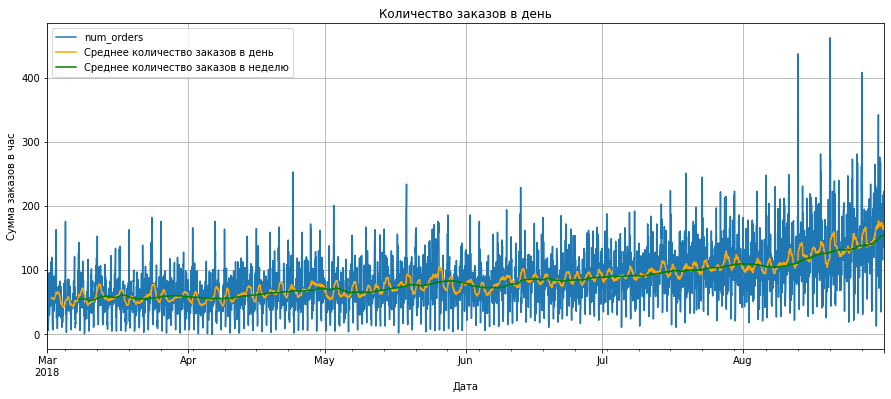

In [45]:
fig, ax = plt.subplots(figsize=(15, 6))
data.plot(title='Количество заказов в день', ax=ax)
data['num_orders'].rolling(window=24).mean().plot(label='Среднее количество заказов в день', color='orange', ax=ax)
data['num_orders'].rolling(window=168).mean().plot(label='Среднее количество заказов в неделю', color='green', ax=ax)
plt.xlabel("Дата")
plt.ylabel('Сумма заказов в час')
plt.legend()
plt.grid(True)
plt.show()

Выполним анализ временного ряда. Мы имеем данные за полгода - с 1 марта по 31 августа 2018 года. Посмотрим тренд за этот период, а также сезонные изменения в пределах недели и дня.

### Тренд
<a name="41"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Ресемплируем данные по дням, чтобы не мешала периодичность более высокого порядка.

In [46]:
decomposed_day = seasonal_decompose(data.resample('1D').sum())

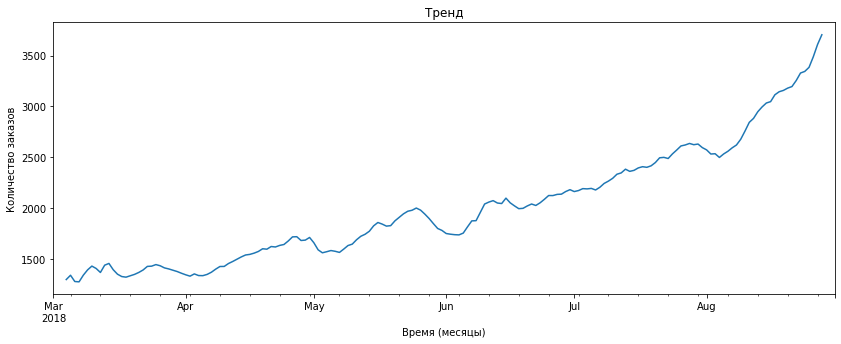

In [47]:
plt.figure(figsize=(14, 5))
decomposed_day.trend.plot(title='Тренд')
plt.xlabel("Время (месяцы)")
plt.ylabel('Количество заказов')
plt.show()

Видно, что на графике хорошо прослеживается рост числа заказов такси в аэропорт за полгода.

### Сезонность
<a name="42"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Взглянем, как изменяется число заказов такси в течение **недели**.

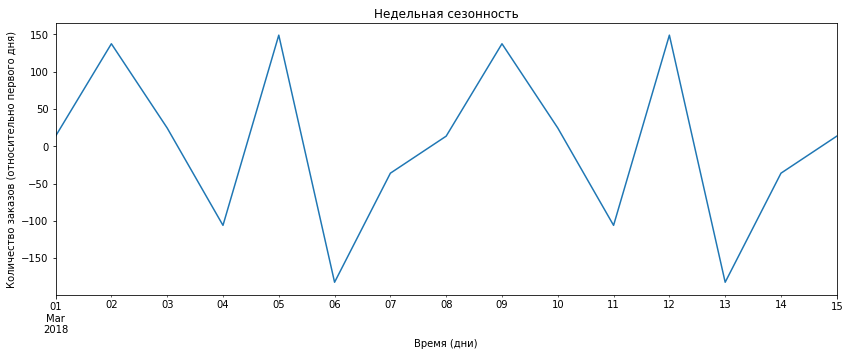

In [48]:
plt.figure(figsize=(14, 5))
decomposed_day.seasonal['2018-03-01':'2018-03-15'].plot(title='Недельная сезонность')
plt.xlabel("Время (дни)")
plt.ylabel('Количество заказов (относительно первого дня)')
plt.show()

На графике нам видны пики - во вторник (02 и 09) и в пятницу (05 и 12). То есть, больше всего заказов такси в аэропорт приходится на начало и конец рабочей недели.

Теперь посмотрим, как изменяется число заказов такси в течение **дня** - для этого воспользуемся ресемплингом по часам.

In [49]:
decomposed_hour = seasonal_decompose(data)

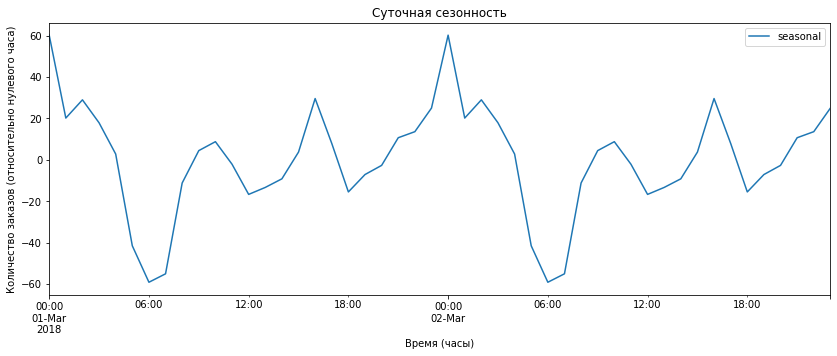

In [50]:
plt.figure(figsize=(14, 5))
decomposed_hour.seasonal['2018-03-01':'2018-03-2'].plot(title='Суточная сезонность')
plt.xlabel("Время (часы)")
plt.ylabel('Количество заказов (относительно нулевого часа)')
plt.legend()
plt.show()

На данном графике видно, что самое непопулярное время - это 6:00. Затем в течение дня наблюдаются несколько пиков: в ~10:00, в ~16:00 и самое популярное, т.е самое загруженное время - в ~00:00.

### Вывод
<a name="43"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

В разделе [**Анализ данных**](#4.-Анализ-данных) были выполнены следующие задачи:
1. выполнен анализ тренда за полугодовой период с 1 марта по 31 августа 2018 года;
2. выполнен анализ сезонных изменений в пределах недели и дня.

В результате выполнения задач этого раздела было выявлено следующее:
1. в течение всего полугодового периода с 1 марта по 31 августа 2018 года прослеживается рост числа заказов такси в аэропорт;
2. в пределах недели: больше всего заказов такси в аэропорт приходится на вторник и пятницу;
3. в пределах дня: самое непопулярное время - 6:00. Затем в течение дня наблюдаются несколько пиков: в ~10:00, в ~16:00 и самое популярное,  т.е. загруженное время - в ~00:00.

## Обучение моделей
<a name="5"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Обучим разные модели с различными гиперпараметрами. Сделаем тестовую выборку размером 10% от исходных данных.

### Разделение данных на выборки
<a name="51"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Разделим данные на обучающую и тестовую выборки в соотношении 9:1.

Отмечаем, что перемешивать выборки в задаче прогнозирования временного ряда нельзя, поэтому укажем аргумент `shuffle` (с англ. «перетасовывать») равным `False`, чтобы разделить данные корректно. Данные обучающей выборки должны предшествовать данным тестовой. Иначе тестирование модели будет некорректным: модель не должна обучаться на данных из будущего.

In [15]:
data_plus.dropna(inplace=True)

X = data_plus.drop('num_orders', axis=1)
y = data_plus['num_orders']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, test_size=TEST_SIZE)

In [16]:
print('Размеры выборок:')
print(f'train: {len(X_train)} - {len(X_train)/len(data):.0%}')
print(f'test: {len(X_test)} - {len(X_test)/len(data):.0%}')

Размеры выборок:
train: 3823 - 87%
test: 425 - 10%


### Функция для обучения моделей
<a name="52"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Создадим и обучим четыре модели: линейную регрессию (*Linear Regression*), случайный лес (*Random Forest*), градиентные бустинги *LightGBM* и *CatBoost*. Качество моделей оценим кросс-валидацией `GridSearchCV` с метрикой *RMSE* и разделением на фолды `TimeSeriesSplit`.

Для начала напишем функцию `fit_model()`, которая будет подбирать лучшую модель с помощью `GridSearchCV`, выводить метрику *RMSE* и параметры лучшей модели.

Укажем параметры для кроссвалидации: `n_splits` - количество фолдов.

In [17]:
ts_cv = TimeSeriesSplit(n_splits=4)

In [18]:
def fit_model(estimator, param_grid, X_train, y_train):
    model = GridSearchCV(estimator=estimator,
                         param_grid=param_grid,
                         n_jobs=-1,
                         cv=ts_cv,
                         scoring='neg_root_mean_squared_error')

    model.fit(X_train, y_train)
    best_rmse = abs(round(model.best_score_, 1))

    print(f'Best RMSE: {best_rmse}')
    print(f'Best params: {model.best_params_}')

    return model.best_estimator_, best_rmse

### `LinearRegression`
<a name="53"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Построим модель линейной регрессии ***Linear Regression***. Будем использовать `Pipeline` для автоматизации предварительных преобразований данных перед обучением модели.

In [19]:
%%time

lr_estimator = Pipeline([('lr', LinearRegression())])

scores = cross_val_score(lr_estimator, 
                         X_train, 
                         y_train, 
                         scoring='neg_root_mean_squared_error', 
                         cv=ts_cv)

rmse_lr = abs(scores.mean())
print(f'RMSE: {rmse_lr:.1f}')

RMSE: 22.9
CPU times: user 606 ms, sys: 732 ms, total: 1.34 s
Wall time: 1.33 s


Построенная модель линейной регрессии **`LinearRegression`** имеет значение метрики оценки качества ***RMSE = 22.9***.

### `RandomForestRegressor`
<a name="54"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Построим модель случайного леса ***Random Forest***, для задачи регрессии.

In [20]:
%%time

rf_param_grid = {
    # максимальная глубина дерева:
    'max_depth': list(range(5, 12, 2)), 
    # количество деревьев:
    'n_estimators': list(range(50, 121, 10))}

rf_best_model = fit_model(
    estimator=RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    param_grid=rf_param_grid,
    X_train=X_train,
    y_train=y_train)

Best RMSE: 23.1
Best params: {'max_depth': 11, 'n_estimators': 120}
CPU times: user 15min 41s, sys: 1.31 s, total: 15min 43s
Wall time: 15min 43s


Лучшая модель случайного леса **`RandomForestRegressor`** имеет значение метрики оценки качества ***RMSE = 23.1*** при следующих гиперпараметрах:
- глубина дерева: `max_depth` = 11;
- количество деревьев: `n_estimators` = 120.

### `LGBMRegressor`
<a name="55"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Построим модель градиентного бустинга ***LightGBM***, для задачи регрессии.

In [21]:
%%time

lgbm_param_grid = {
    # максимальная глубина дерева:
    'max_depth': range(4, 9, 2), 
    # количество деревьев (итераций):
    'n_estimators': range(100, 201, 50),
    # коэффициент скорости обучения (размер шага градиентного спуска):
    'learning_rate': [0.01, 0.05, 0.1]}

lgbm_best_model = fit_model(
    estimator=LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    param_grid=lgbm_param_grid,
    X_train=X_train,
    y_train=y_train)

Best RMSE: 22.8
Best params: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 150}
CPU times: user 21min 23s, sys: 10.3 s, total: 21min 33s
Wall time: 21min 42s


Лучшая модель градиентного бустинга **`LGBMRegressor`** имеет значение метрики оценки качества ***RMSE = 22.8*** при следующих гиперпараметрах:
- глубина дерева: `max_depth` = 4;
- количество деревьев (итераций): `n_estimators` = 150;
- коэффициент скорости обучения (размер шага градиентного спуска): `learning_rate` = 0.05.

### `CatBoostRegressor`
<a name="56"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Построим модель градиентного бустинга ***CatBoost*** для задачи регрессии.

Здесь нужно отметить, что `CatBoostRegressor` создает временные файлы для обучения. Укажем в модели параметр `allow_writing_files=False`, чтобы не появлялась ошибка о том, что по указанными путям у `CatBoostRegressor` нет доступа к созданию файлов.

In [22]:
%%time

catboost_param_grid = {
    # глубина дерева
    'depth': range(2, 12, 3), 
    # количество итераций
    'iterations': range(250, 301, 50), 
    # коэффициент скорости обучения (размер шага градиентного спуска)
    'learning_rate': [0.05, 0.1, 0.15]}

catboost_best_model = fit_model(
    estimator=CatBoostRegressor(random_state=RANDOM_STATE, 
                                verbose=False, allow_writing_files=False),
                                param_grid=catboost_param_grid,
                                X_train=X_train, y_train=y_train)

Best RMSE: 22.7
Best params: {'depth': 5, 'iterations': 250, 'learning_rate': 0.05}
CPU times: user 1h 5min 51s, sys: 6.83 s, total: 1h 5min 57s
Wall time: 1h 5min 59s


Лучшая модель градиентного бустинга **`CatBoostRegressor`** имеет значение метрики оценки качества ***RMSE = 22.7*** при следующих гиперпараметрах:
- глубина дерева: `depth` = 5;
- количество итераций: `iterations` = 250;
- коэффициент скорости обучения (размер шага градиентного спуска): `learning_rate` = 0.05.

### Сравнение моделей
<a name="57"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Выведем итоговые значения метрики *RMSE* различных моделей в виде таблицы.

In [23]:
table = pd.DataFrame([
    ['LinearRegression', f'{rmse_lr:.1f}'],
    ['RandomForestRegressor', f'{rf_best_model[1]:.1f}'],
    ['LGBMRegressor', f'{lgbm_best_model[1]:.1f}'],
    ['CatBoostRegressor', f'{catboost_best_model[1]:.1f}']
],
columns=['model', 'RMSE'])

table

,model,RMSE
0,LinearRegression,22.9
1,RandomForestRegressor,23.1
2,LGBMRegressor,22.8
3,CatBoostRegressor,22.7


По итогу, в качестве лучшей модели нам следует выбрать модель **градиентного бустинга** **`CatBoostRegressor`**, т.к. значение метрики ***RMSE = 22.7*** у неё меньше остальных моделей.

### Вывод
<a name="58"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

В разделе [**Обучение моделей**](#5.-Обучение-моделей) были выполнены следующие задачи:
1. Данные разделены на выборки, без перемешивания, в соотношении 9:1.
2. Написана функция `fit_model()`, которая подбирает лучшую модель используя функцию `GridSearchCV`, выводит метрику *RMSE* и параметры лучшей модели.
3. Обучены четыре модели (`LinearRegression`, `RandomForestRegressor`, `LGBMRegressor` и `CatBoostRegressor`) с различными гиперпараметрами.
4. Выведены значения метрики *RMSE* различных моделей в виде таблицы.


В результате выполнения задач этого раздела было выявлено следующее:
- Лучшая модель градиентного бустинга **`CatBoostRegressor`** **на обучающей выборке** имеет значение метрики оценки качества ***RMSE = 26.0*** при следующих гиперпараметрах:
    - глубина дерева: `max_depth` = 5;
    - количество деревьев `n_estimators` (или итераций `iterations`):  250;
    - коэффициент скорости обучения (размер шага градиентного спуска): `learning_rate` = 0.05.

## Тестирование лучшей модели
<a name="6"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

### Качество модели
<a name="61"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Проверим качесто выбранной модели градиентного бустинга **`CatBoostRegressor`** на **тестовой** выборке.

In [28]:
pred = catboost_best_model[0].predict(X_test)

# параметр squared=False возвращает метрику RMSE
rmse = mean_squared_error(y_test, pred, squared=False) 
print(f'RMSE на тестовой выборке: {rmse:.1f}')

RMSE на тестовой выборке: 36.8


Итак, лучшая модель градиентного бустинга **`CatBoostRegressor`** на тестовой выборке имеет значение метрики оценки качества ***RMSE = 36.8***.

### Зависимость количества заказов от времени
<a name="62"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Построим график зависимости истинных и предсказанных значений количества заказов от времени, для тестовой выборки.

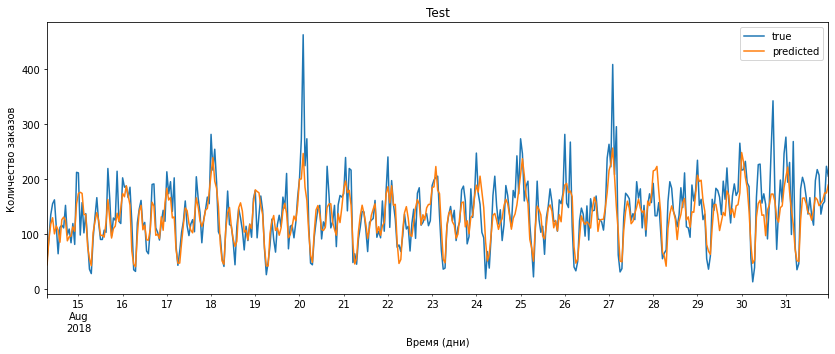

In [29]:
pred = pd.Series(pred, index=y_test.index)

plt.figure(figsize=(14, 5))
y_test.plot(label='true', title='Test')
pred.plot(label='predicted')
plt.legend()
plt.xlabel("Время (дни)")
plt.ylabel('Количество заказов')
plt.show()

График показывает, что зависимости истинных и предсказанных значений количества заказов от времени имеют схожий характер.

### Вывод
<a name="63"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

В разделе [**Тестирование лучшей модели**](#6.-Тестирование-лучшей-модели) были выполнены следующие задачи:
1. проверено качесто выбранной, лучшей модели **`CatBoostRegressor`** на тестовой выборке;
2. построен график зависимости истинных и предсказанных значений количества заказов от времени, для тестовой выборки.

В результате выполнения задач этого раздела было выявлено следующее:
1. лучшая модель **градиентного бустинга** **`CatBoostRegressor`** на тестовой выборке имеет значение метрики оценки качества ***RMSE = 36.8***;
2. значение метрики ***RMSE*** **на тестовой выборке** не превышает ***48***, что соответствует изначальному требованию в условии задачи проекта.

## Общий вывод
<a name="7"></a> <div style="text-align: left">[Cодержание](#Содержание)</div>

Нами проведено исследование, с целью построения модели машинного обучения, которая поможет предсказать количество заказов такси на следующий час.

Входные данными были исторические данные о заказах такси в аэропортах за полгода - с 1 марта по 31 августа 2018 года.

В разделе [**подготовки данных**](#3.-Подготовка-данных) данные были загружены, в качестве индекса датасета установлен признак datetime с типом данных datetime64. Выполнили ресемплирование данных по одному часу, создали новые признаки - календарные (день недели и час), отстающие значения и скользящее среднее. Даты и время в датафрейме расположены в хронологическом порядке.

В разделе [**анализа данных**](#4.-Анализ-данных) были выполнены анализ тренда за полугодовой период с 1 марта по 31 августа 2018 года и анализ сезонных изменений в пределах недели и дня. 

В результате данного анализа выяснилось, что:
1. в течение всего полугодового периода с 1 марта по 31 августа 2018 года прослеживается рост числа заказов такси в аэропорт;
2. в пределах недели: больше всего заказов такси в аэропорт приходится на вторник и пятницу;
3. в пределах дня: самое непопулярное время - 6:00. Затем в течение дня наблюдаются несколько пиков: в ~10:00, в ~16:00 и самое популярное,  загруженное время - в ~00:00.

В разделе [**обучения моделей**](#5.-Обучение-моделей) данные были разделены на выборки, без перемешивания, в соотношении 9:1. Написана функция для подбора лучшей модели, вывода метрики *RMSE* и параметров лучшей модели. Обучены четыре модели (`LinearRegression`, `RandomForestRegressor`, `LGBMRegressor` и `CatBoostRegressor`) с различными гиперпараметрами. Выведены значения метрики *RMSE* различных моделей в виде таблицы.

В ходе исследования удалось получить следующие результаты **на обучающей выборке**:

1. Модель линейной регрессии **`LinearRegression`** имеет значение метрики оценки качества ***RMSE = 22.9***.


2. Лучшая модель случайного леса **`RandomForestRegressor`** имеет значение метрики оценки качества ***RMSE = 23.1*** при следующих параметрах:
    - глубина дерева: `max_depth` = 11;
    - количество деревьев: `n_estimators` = 120.


3. Лучшая модель градиентного бустинга **`LGBMRegressor`** имеет значение метрики оценки качества ***RMSE = 22.8*** при следующих параметрах:
    - глубина дерева: `max_depth` = 4;
    - количество деревьев (итераций): `n_estimators` = 150;
    - коэффициент скорости обучения (размер шага градиентного спуска): `learning_rate` = 0.05.
   

4. Лучшая модель градиентного бустинга **`CatBoostRegressor`** имеет значение метрики оценки качества ***RMSE = 22.7*** при следующих параметрах:
    - глубина дерева: `depth` = 5;
    - количество итераций: `iterations` = 250;
    - коэффициент скорости обучения (размер шага градиентного спуска): `learning_rate` = 0.05.
   

В разделе [**тестирования лучшей модели**](#6.-Тестирование-лучшей-модели) было проверено качесто выбранной, лучшей модели **`LGBMRegressor`** на тестовой выборке и построен график зависимости истинных и предсказанных значений количества заказов от времени, для тестовой выборки.

В результате выполнения тестирования были получены результаты:
- лучшая модель **градиентного бустинга** **`CatBoostRegressor`** на тестовой выборке имеет значение метрики оценки качества ***RMSE = 36.8***;

______________________ ______________________ ______________________
Исходя из полученных результатов, можно сделать следующий **вывод**:

- лучшая модель **градиентного бустинга** **`CatBoostRegressor`** на **тестовой выборке** имеет значение метрики оценки качества ***RMSE = 36.8***, что не превышает ***48***, а значит соответствует изначальному требованию в условии задачи проекта.
______________________ ______________________ ______________________   
**Общие рекомендации:**

Специалистам компании агрегатора такси, занимающимся вопросами регулирования количества водителей в различные периоды нагрузки, можно рекомендовать использовать полученную модель **`CatBoostRegressor`**.

Результаты исследования позволят привлечь больше водителей в период пиковой нагрузки.
______________________ ______________________ ______________________
На этом мы заканчиваем. Благодарим вас за внимание, надеемся, что наше исследование вам понравилось и поможет сделать правильные выводы, принять правильные решения.